## Assignment 4 Submission

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### Q1

We perform Metropolis with Gibbs sampling algorithm by setting:

Prior $p(\tau) \sim \text{Gamma}(\text{shape} = 2, \text{scale}=2), p(\theta) \sim N(1,1)$.

Proposal distribution for $\tau$, $q(\tilde{\tau}^{(t)}|\tau^{(t-1)}) = q(\tilde{\tau}^{(t)}) \sim \text{Exponential}(\text{scale}=2)$

and for $\theta$, $q(\tilde{\theta}^{(t)}|\theta^{(t-1)}) \sim N(\theta^{(t-1)}, 5^2)$.

In [14]:
import warnings
warnings.filterwarnings("ignore")

# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 20  # initialization
tau[:, 0] = 10
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau_target = lambda tau_ :  np.prod(stats.norm(loc=theta[c,g-1], scale=1/tau_**0.5).pdf(x)) * \
                                                     stats.gamma(a=2, scale=1/2).pdf(tau_) # prior
        tau_prop_dist = stats.expon(scale=2) # proposal
        tau_tilde = tau_prop_dist.rvs()
        mh_calc = (tau_target(tau_tilde)/tau_target(tau[c,g-1])) * (tau_prop_dist.pdf(tau[c,g-1])/tau_prop_dist.pdf(tau_tilde))
        accept_rate = min(1, mh_calc)
        if stats.uniform().rvs() < accept_rate:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]
        # print("accept", accept_rate)
        # print("tau", tau[c,g])

        theta_target = lambda theta_ : np.prod(stats.norm(loc=theta_, scale=1/tau[c,g]**0.5).pdf(x)) * \
                                                stats.norm(loc=1, scale=1).pdf(theta_) # prior
        theta_prop_dist = stats.norm(loc=theta[c,g-1], scale=5)
        theta_tilde = theta_prop_dist.rvs()
        mh_calc = (theta_target(theta_tilde)/theta_target(theta[c,g-1])) #* (theta_prop_dist.pdf(theta[c,g-1])/theta_prop_dist.pdf(theta_tilde))
        accept_rate = min(1, mh_calc)
        if stats.uniform().rvs() < accept_rate:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]
        # print("accept", accept_rate)
        # print("theta", theta[c,g])

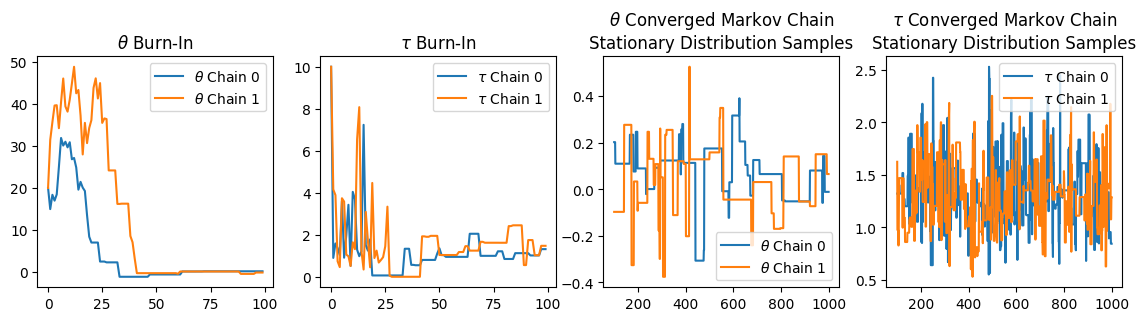

In [15]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 100
demo = 1000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

The 95% credible interval of mean for first chain is [-0.2517181446727068, 0.36531793549929675]
The 95% credible interval of standard deviation for first chain is [0.6935264038652097, 1.133024489783051]


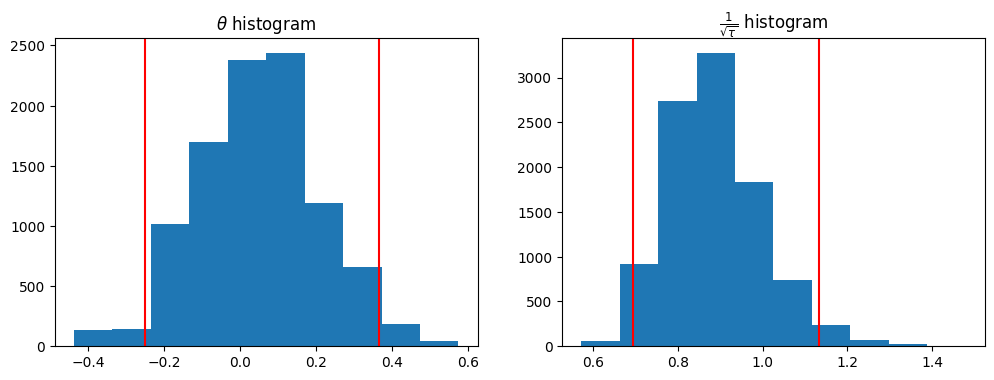

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title("$\\theta$ histogram")
ax[1].set_title("$\\frac{1}{\\sqrt{\\tau}}$ histogram")

ax[0].hist(theta[0, burn:])
lower, upper = np.quantile(theta[0, burn:], (0.025, 0.975))
ax[0].axvline(lower, color="r")
ax[0].axvline(upper, color="r")
print(f"The 95% credible interval of mean for first chain is {[lower, upper]}")

ax[1].hist(1/tau[0, burn:]**0.5)
lower, upper = np.quantile(1/tau[0, burn:]**0.5, (0.025, 0.975))
ax[1].axvline(lower, color="r")
ax[1].axvline(upper, color="r")
print(f"The 95% credible interval of standard deviation for first chain is {[lower, upper]}")


The Metropolis within Gibbs sampling algorithm is able to sample from the posterior distribution without knowing the distribution of the full conditional. Comparing with Gibbs sampling, this algorithm has a longer burn-in period, in general (depends on the prior, and proposal distribution). Comparing the result, we can see that the performance of Metropolis within Gibbs is comparable with the one Gibbs sampling algorithm. However, the performance of this algorithm highly depends on the prior and proposal distribution.

### Q2

Now, we choose prior for $\theta$ as $p(\theta) \sim  \text{Cauchy distribution}$, \
and choose the proposal for $\tau$ as $q(\tilde{\tau}^{(t)}|\tau^{(t-1)}) \sim TN(\mu = \tau^{(t-1)}, \sigma^2 = s^2, a = -\frac{\tau^{(t-1)}}{s}, b = \infty)$. We let $s = 1$ in this case.

Note that the truncated normal distribution is not symmetric due to asymmetric truncation (observe the value of $a$ and $b$).

In [17]:
# import warnings
# warnings.filterwarnings("ignore")

# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 20  # initialization
tau[:, 0] = 10
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau_target = lambda tau_ :  np.prod(stats.norm(loc=theta[c,g-1], scale=1/tau_**0.5).pdf(x)) * \
                                                     stats.expon(scale=1).pdf(tau_) # prior
        tau_prop_dist = lambda tau_t_minus_1 : stats.truncnorm(a = -tau_t_minus_1/1, b = np.inf,
                                                               loc = tau_t_minus_1, scale = 1) # proposal
        tau_tilde = tau_prop_dist(tau[c,g-1]).rvs()
        mh_calc = (tau_target(tau_tilde)/tau_target(tau[c,g-1])) * \
            (tau_prop_dist(tau_tilde).pdf(tau[c,g-1])/tau_prop_dist(tau[c,g-1]).pdf(tau_tilde))
        accept_rate = min(1, mh_calc)
        if stats.uniform().rvs() < accept_rate:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]

        theta_target = lambda theta_ : np.prod(stats.norm(loc=theta_, scale=1/tau[c,g]**0.5).pdf(x)) * \
                                                stats.cauchy().pdf(theta_) # prior
        theta_prop_dist = stats.norm(loc=theta[c,g-1], scale=5)
        theta_tilde = theta_prop_dist.rvs()
        mh_calc = (theta_target(theta_tilde)/theta_target(theta[c,g-1])) #* (theta_prop_dist.pdf(theta[c,g-1])/theta_prop_dist.pdf(theta_tilde))
        accept_rate = min(1, mh_calc)
        if stats.uniform().rvs() < accept_rate:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]

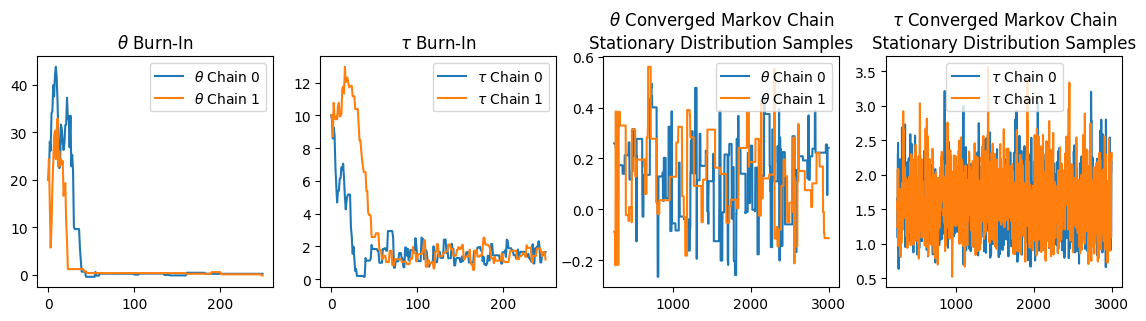

In [20]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 250 # some chains need this many burn-in period to converge
demo = 3000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

The 95% credible interval of mean for first chain is [-0.15414975255270844, 0.43035054183478916]
The 95% credible interval of standard deviation for first chain is [0.6410421860634026, 1.0576465555439718]


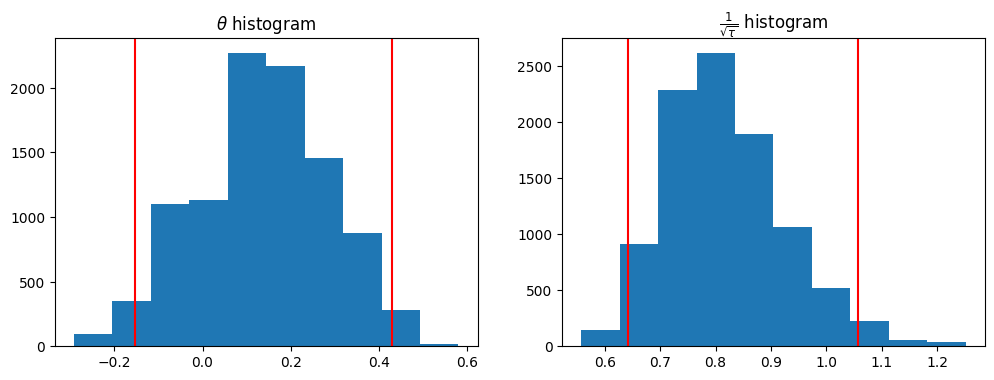

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title("$\\theta$ histogram")
ax[1].set_title("$\\frac{1}{\\sqrt{\\tau}}$ histogram")

ax[0].hist(theta[0, burn:])
lower, upper = np.quantile(theta[0, burn:], (0.025, 0.975))
ax[0].axvline(lower, color="r")
ax[0].axvline(upper, color="r")
print(f"The 95% credible interval of mean for first chain is {[lower, upper]}")

ax[1].hist(1/tau[0, burn:]**0.5)
lower, upper = np.quantile(1/tau[0, burn:]**0.5, (0.025, 0.975))
ax[1].axvline(lower, color="r")
ax[1].axvline(upper, color="r")
print(f"The 95% credible interval of standard deviation for first chain is {[lower, upper]}")


This shows that we need not to analyze the distribution of the full conditional as it can also sample from the target distribution without knowing the posterior distribution. The only thing we need to know is the product of joint and prior function to be able to sample from the posterior. However, the chain might need to have more burn-in samples (like in this question) because of the slow convergence rate from unfamiliar prior and proposal distribution. The number of burn-in samples is highly depends on the prior, the proposal, initial value.

### Q3

Observe that
\begin{align*}
q(\tilde x^{(t)} | x^{(t-1)}) &= \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \\
&= \frac{1}{2} \\
\frac{q(x^{(t-1)} | \tilde x^{(t)})}{q(\tilde x^{(t)} | x^{(t-1)})} &= 1 &\text{(Therefore, we can cancel this term.)}
\end{align*}

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right]$

Now, consider $\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0)$,
\begin{align*}
    \Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) &= \Pr(\text{accept} \ \tilde{x}^{(t+1)} = 0 | x^{(t)}=0) + \Pr(\text{reject} \ \tilde{x}^{(t+1)} = 1 | x^{(t)}=0) \\
    &= q(\tilde x^{(t+1)}=0 | x^{(t)}=0)\min\left(1,\frac{p(\tilde x^{(t+1)}=0)}{p(x^{(t)}=0)}\right) + q(\tilde x^{(t+1)}=1 | x^{(t)}=0)\left(1-\min\left(1,\frac{p(\tilde x^{(t+1)}=1)}{p(x^{(t)}=0)}\right)\right) \\
    &= \frac{1}{2} \cdot 1 + \frac{1}{2} \cdot 0 \\
    &= \frac{1}{2} \\
    \Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1) &= 1-\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) \\
    &= \frac{1}{2}
\end{align*}

Likewise,
\begin{align*}
    \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0) &= \Pr(\text{accept} \ \tilde{x}^{(t+1)} = 0 | x^{(t)}=1) + \Pr(\text{reject} \ \tilde{x}^{(t+1)} = 1 | x^{(t)}=1) \\
    &= q(\tilde x^{(t+1)}=0 | x^{(t)}=1)\min\left(1,\frac{p(\tilde x^{(t+1)}=0)}{p(x^{(t)}=1)}\right) + q(\tilde x^{(t+1)}=1 | x^{(t)}=1)\left(1-\min\left(1,\frac{p(\tilde x^{(t+1)}=1)}{p(x^{(t)}=1)}\right)\right) \\
    &= \frac{1}{2} \cdot \frac{1}{2} + \frac{1}{2} \cdot 0 \\
    &= \frac{1}{4} \\
    \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1) &= 1-\Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0) \\
    &= \frac{3}{4}
\end{align*}